In [1]:
#import library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Bidirectional

In [2]:
# Read the dataset
df = pd.read_csv('../Dataset/BID-Historical-Data_Group-9.csv',index_col='Date', parse_dates=True)
df.dropna() #Drop missing value
df = df.sort_values(by='Date', ascending=True)
df =df.reset_index(drop=True) #Reset the index
print(df)

          Price       Open       High        Low     Vol. Change %
0     25,141.50  24,950.20  25,332.90  24,950.20    1.45M    1.08%
1     25,715.50  25,332.90  25,830.30  25,256.30    1.15M    2.28%
2     26,480.90  25,409.40  27,016.60  25,409.40    5.30M    2.98%
3     26,595.70  26,480.90  26,710.50  26,327.80    2.01M    0.43%
4     26,710.50  26,787.00  26,978.30  26,557.40    2.14M    0.43%
...         ...        ...        ...        ...      ...      ...
1308  48,900.00  49,400.00  49,400.00  48,550.00  763.20K   -0.61%
1309  49,100.00  49,000.00  49,200.00  48,600.00    1.23M    0.41%
1310  48,600.00  49,450.00  49,450.00  48,600.00    1.39M   -1.02%
1311  47,700.00  48,400.00  48,500.00  47,400.00    2.09M   -1.85%
1312  47,100.00  47,700.00  48,300.00  47,100.00    1.97M   -1.26%

[1313 rows x 6 columns]


In [3]:
print(df.dtypes)

Price       object
Open        object
High        object
Low         object
Vol.        object
Change %    object
dtype: object


In [4]:
# Hàm chuyển đổi
def convert_str_to_number(str):
    return float(str.replace(',', ''))

def convert_change_to_number(change_str):
    return float(change_str.strip('%')) / 100

def convert_volume_to_number(volume_str):
    factor = {'K': 1000, 'M': 1000000, 'B': 1000000000}
    return int(float(volume_str[:-1]) * factor[volume_str[-1]]) if volume_str[-1] in factor else int(volume_str)

# Áp dụng hàm chuyển đổi cho các cột giá trị
df['Price'], df['Open'], df['High'], df['Low'] = [df[col].apply(convert_str_to_number) for col in ['Price', 'Open', 'High', 'Low']]
df['Change %'] = df['Change %'].apply(convert_change_to_number)
df["Vol."] = df["Vol."].apply(convert_volume_to_number)

print(df)
df.describe()

        Price     Open     High      Low     Vol.  Change %
0     25141.5  24950.2  25332.9  24950.2  1450000    0.0108
1     25715.5  25332.9  25830.3  25256.3  1150000    0.0228
2     26480.9  25409.4  27016.6  25409.4  5300000    0.0298
3     26595.7  26480.9  26710.5  26327.8  2009999    0.0043
4     26710.5  26787.0  26978.3  26557.4  2140000    0.0043
...       ...      ...      ...      ...      ...       ...
1308  48900.0  49400.0  49400.0  48550.0   763200   -0.0061
1309  49100.0  49000.0  49200.0  48600.0  1230000    0.0041
1310  48600.0  49450.0  49450.0  48600.0  1390000   -0.0102
1311  47700.0  48400.0  48500.0  47400.0  2089999   -0.0185
1312  47100.0  47700.0  48300.0  47100.0  1970000   -0.0126

[1313 rows x 6 columns]


,Price,Open,High,Low,Vol.,Change %
count,1313.000000,1313.000000,1313.000000,1313.000000,1.313000e+03,1313.000000
mean,35290.396420,35290.707388,35805.167479,34820.149429,2.018955e+06,0.000722
std,6519.054229,6544.786381,6627.970793,6453.353467,1.446782e+06,0.021709
min,23419.500000,23419.500000,24108.300000,22958.500000,1.838000e+05,-0.099300
25%,30970.000000,30970.000000,31325.000000,30613.700000,1.090000e+06,-0.009200
50%,34120.000000,34110.600000,34625.000000,33635.800000,1.650000e+06,0.000000
75%,39356.000000,39400.000000,39846.500000,38912.000000,2.460000e+06,0.012000
max,54400.000000,54400.000000,56700.000000,53500.000000,1.638000e+07,0.070000


In [5]:
df1=df.reset_index()['Price']
df1

0       25141.5
1       25715.5
2       26480.9
3       26595.7
4       26710.5
         ...   
1308    48900.0
1309    49100.0
1310    48600.0
1311    47700.0
1312    47100.0
Name: Price, Length: 1313, dtype: float64

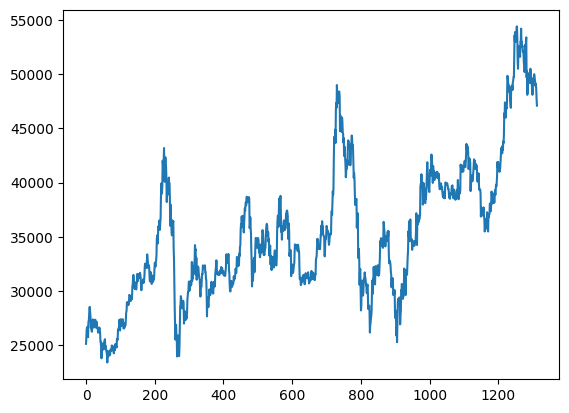

In [6]:
plt.plot(df1)

## LSTM are sentitive to the scale of the data => apply MinMax schaler

In [7]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [8]:
# df1.shape
print(df1)

[[0.05558335]
 [0.07411113]
 [0.098817  ]
 ...
 [0.81278546]
 [0.78373493]
 [0.76436791]]


In [9]:
# 4. split the data into train and test
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size 

train_data = df1[0:train_size,:]
test_data = df1[train_size:len(df1),:1]

In [10]:
#Training process
# a. convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

# b. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# c. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [11]:
print(X_train)

[[[0.05558335]
  [0.07411113]
  [0.098817  ]
  ...
  [0.12722519]
  [0.11487226]
  [0.09511144]]

 [[0.07411113]
  [0.098817  ]
  [0.10252255]
  ...
  [0.11487226]
  [0.09511144]
  [0.11363922]]

 [[0.098817  ]
  [0.10252255]
  [0.10622811]
  ...
  [0.09511144]
  [0.11363922]
  [0.12846145]]

 ...

 [[0.22796598]
  [0.22367296]
  [0.20646859]
  ...
  [0.19358952]
  [0.17783767]
  [0.11337777]]

 [[0.22367296]
  [0.20646859]
  [0.22651345]
  ...
  [0.17783767]
  [0.11337777]
  [0.14058843]]

 [[0.20646859]
  [0.22651345]
  [0.232259  ]
  ...
  [0.11337777]
  [0.14058843]
  [0.15204726]]]


In [12]:
# # 8. Build LSTM modal

# # Define the model
# model = Sequential()

# # Add a 1D convolutional layer
# model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(100,1)))

# # Add a max pooling layer
# model.add(MaxPooling1D(pool_size=2))

# # Add another 1D convolutional layer
# model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))

# # Add a bidirectional LSTM layer
# model.add(Bidirectional(LSTM(100, activation='relu')))

# # Add a dense output layer
# model.add(Dense(1))
# model.compile(loss='mean_squared_error',optimizer='adam')

In [13]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

c:\Users\mikey\OneDrive\Desktop\LSTM\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100, 50)        │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - loss: 0.0538 - val_loss: 0.0650
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 260ms/step - loss: 0.0122 - val_loss: 0.0098
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 276ms/step - loss: 0.0074 - val_loss: 0.0146
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 245ms/step - loss: 0.0054 - val_loss: 0.0091
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 296ms/step - loss: 0.0057 - val_loss: 0.0056
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 252ms/step - loss: 0.0048 - val_loss: 0.0067
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 265ms/step - loss: 0.0037 - val_loss: 0.0104
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 287ms/step - loss: 0.0040 - val_loss: 0.0069
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 295ms/step - loss: 0.0037 - val_loss: 0.0024
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 284ms/step - loss: 0.0038 - val_loss: 0.0024
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 301ms/step - loss: 0.0032 - val_loss: 0.0040
Epoch 12/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 

In [16]:
# 10. Dự báo dữ liệu test
# train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 710ms/step


In [17]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
# train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

In [18]:
##Transformback to original form
y_test = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
# 12. Đánh giá độ chính xác thuật toán 
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Testing RMSE:', test_rmse)

from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_test, y_pred)
print('Testing MAE:', test_mae)

from sklearn.metrics import mean_absolute_percentage_error
test_mape = mean_absolute_percentage_error(y_test, y_pred)
print('Testing MAPE:', test_mape)   

Testing RMSE: 1447.374150617815
Testing MAE: 1278.3569752559727
Testing MAPE: 0.029189799983517156


In [20]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_test,y_pred))

1447.374150617815

In [21]:
len(test_data)

394

In [22]:
# x_input = test_data[162:].reshape(1,-1)
# x_input.shape

In [23]:
# temp_input = list(x_input)
# temp_input = temp_input[0].tolist()

In [24]:
# temp_input

In [25]:
# 12. Dự báo 30 ngày tiếp theo
x_input = test_data[60:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output_30 = []
n_steps = 100
i = 0

while i < 30:
    if len(temp_input) > 100:
        # print(temp_input)
        x_input = np.array(temp_input[-100:])  # Ensure x_input has exactly 100 elements
        # print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        # print(x_input)
        yhat = model.predict(x_input, verbose=0)
        # print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        # print(temp_input)
        lst_output_30.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = np.array(temp_input)  # Use the available elements
        x_input = x_input.reshape((1, len(temp_input), 1))  # Reshape according to the actual length
        yhat = model.predict(x_input, verbose=0)
        # print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        # print(len(temp_input))
        lst_output_30.extend(yhat.tolist())
        i = i + 1

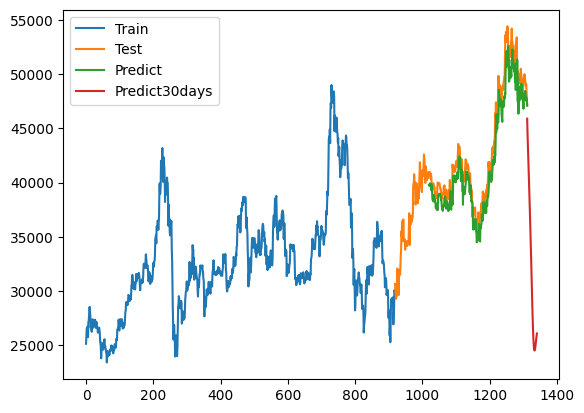

In [26]:
# 15.Vẽ hình dự báo 30 ngày tiếp theo

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output_30))
plt.legend(['Train','Test','Predict','Predict30days'])
plt.show()

In [27]:
# 12. Dự báo 60 ngày tiếp theo
x_input = test_data[60:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output_60 = []
n_steps = 100
i = 0

while i < 60:
    if len(temp_input) > 100:
        # print(temp_input)
        x_input = np.array(temp_input[-100:])  # Ensure x_input has exactly 100 elements
        # print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        # print(x_input)
        yhat = model.predict(x_input, verbose=0)
        # print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        # print(temp_input)
        lst_output_60.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = np.array(temp_input)  # Use the available elements
        x_input = x_input.reshape((1, len(temp_input), 1))  # Reshape according to the actual length
        yhat = model.predict(x_input, verbose=0)
        # print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        # print(len(temp_input))
        lst_output_60.extend(yhat.tolist())
        i = i + 1

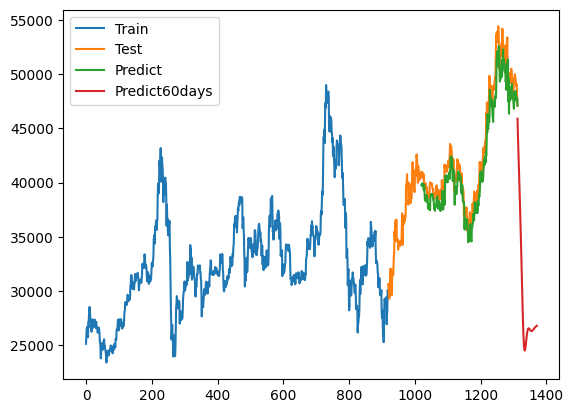

In [28]:
# 15. Vẽ hình dự báo 30 ngày tiếp theo
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index, (y_pred))

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)-1+len(scaler.inverse_transform(lst_output_60)), step=1)
plt.plot(prediect_data_index, scaler.inverse_transform(lst_output_60))

plt.legend(['Train', 'Test', 'Predict', 'Predict60days'])
plt.show()

In [29]:
# 12. Dự báo 60 ngày tiếp theo
x_input = test_data[60:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output_90 = []
n_steps = 100
i = 0

while i < 90:
    if len(temp_input) > 100:
        # print(temp_input)
        x_input = np.array(temp_input[-100:])  # Ensure x_input has exactly 100 elements
        # print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        # print(x_input)
        yhat = model.predict(x_input, verbose=0)
        # print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        # print(temp_input)
        lst_output_90.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = np.array(temp_input)  # Use the available elements
        x_input = x_input.reshape((1, len(temp_input), 1))  # Reshape according to the actual length
        yhat = model.predict(x_input, verbose=0)
        # print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        # print(len(temp_input))
        lst_output_90.extend(yhat.tolist())
        i = i + 1

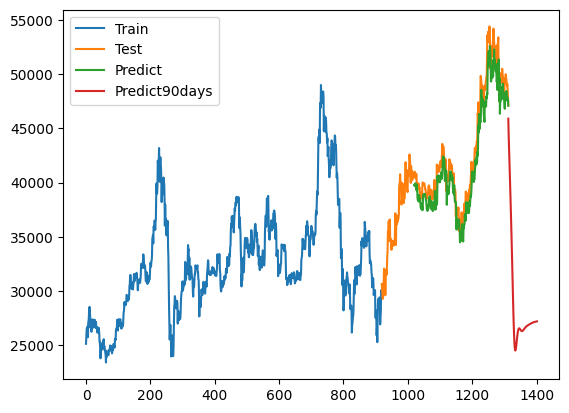

In [30]:
# 15. Vẽ hình dự báo 30 ngày tiếp theo
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index, (y_pred))

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)-1+len(scaler.inverse_transform(lst_output_90)), step=1)
plt.plot(prediect_data_index, scaler.inverse_transform(lst_output_90))

plt.legend(['Train', 'Test', 'Predict', 'Predict90days'])
plt.show()